# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [22]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
import time

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [6]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027207103e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [8]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
1.79412040779e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [9]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 3.561318e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 4.447656e-11
b1 max relative error: 2.999856e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.0171496079387


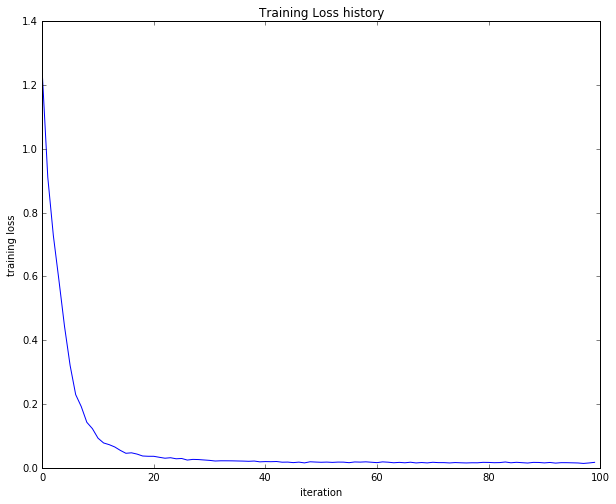

In [10]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=False)

print 'Final training loss: ', stats['loss_history'][-1]

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [11]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [18]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc



iteration 0 / 1000: loss 2.302976
iteration 100 / 1000: loss 2.302487
iteration 200 / 1000: loss 2.298445
iteration 300 / 1000: loss 2.272842
iteration 400 / 1000: loss 2.160314
iteration 500 / 1000: loss 2.144013
iteration 600 / 1000: loss 2.070936
iteration 700 / 1000: loss 1.976521
iteration 800 / 1000: loss 1.951775
iteration 900 / 1000: loss 1.958305
Validation accuracy:  0.28


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

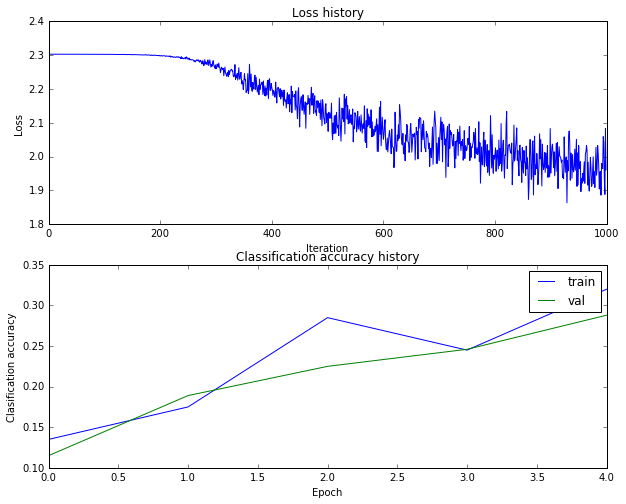

In [14]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

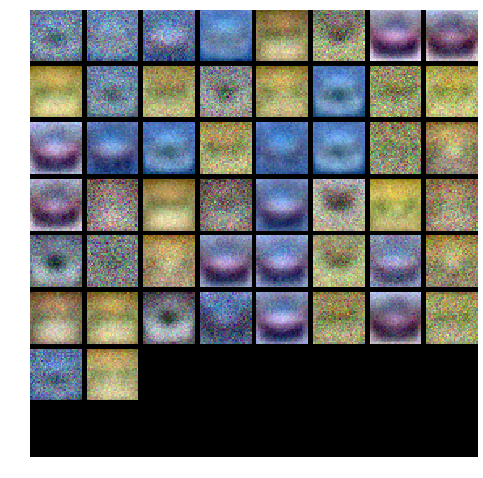

In [15]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [153]:
# Plot the loss function and train / validation accuracies
def show_stats_history(stats):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.legend()
    plt.show()
    
def eval_acc(net, X,y):
    # Predict on the validation set 
    return (net.predict(X) == y).mean()

def show_results(results, best_params, lr_ranges=lr_ranges_exp, reg_ranges=reg_ranges_exp):
    print "\nFinal Evaluations"
    for k,r in results.items():
        print "HS: {} #iter: {} #batch: {} LR: {:.8f}  Reg: {:.8f} ACC Test: {:5.3} Val: {:5.3} Test {:5.3f}".format(*(list(k)+list(r[:3])))
    print "Best result: "
    print "HS: {} #iter: {} #batch: {} LR: {:.8f}  Reg: {:.8f} ACC Test: {:5.3} Val: {:5.3} Test {:5.3f}".format(*(list(params)+list(results[best_params][:3])))
    lr,reg,at,av = np.array([[k[3],k[4],r[0],r[1]] for k,r in results.items()]).T
    plt.figure()
    plt.subplot(221)
    plt.plot(lr,at,'xr',label="Train")
    plt.plot(lr,av,'+',label="Val")
    plt.title("Accuracy over Learning Rate")
    plt.subplot(223)
    plt.semilogx(lr,at,'xr',label="Train")
    plt.semilogx(lr,av,'+',label="Val")
    plt.title("Accuracy over Learning Rate")
    plt.subplot(222)
    plt.plot(reg,at,'xr',label="Train")
    plt.plot(reg,av,'+',label="Val")
    plt.title("Regularization over Learning Rate")
    plt.subplot(224)
    plt.semilogx(reg,at,'xr',label="Train")
    plt.semilogx(reg,av,'+',label="Val")
    plt.title("Regularization over Learning Rate")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.scatter(lr, reg, marker='x',c=av, cmap=plt.get_cmap("jet"))
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlim(*(10.0**lr_ranges)*np.array([0.9,1.1])) # Fix the x limits to fit all the points
    plt.ylim(*(10.0**reg_ranges)*np.array([0.9,1.1])) # Fix the x limits to fit all the points
    plt.colorbar();

In [155]:
lr_ranges_exp = np.array([-4.5,-2.6])
reg_ranges_exp = np.array([-5,-1])



Run 1 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00029561  Reg: 0.01056643
iteration 0 / 1201: loss 2.302612
iteration 100 / 1201: loss 2.242745
iteration 200 / 1201: loss 2.051263
iteration 300 / 1201: loss 1.926921
iteration 400 / 1201: loss 1.871665
iteration 500 / 1201: loss 1.868870
iteration 600 / 1201: loss 1.784361
iteration 700 / 1201: loss 1.796142
iteration 800 / 1201: loss 1.688654
iteration 900 / 1201: loss 1.773947
iteration 1000 / 1201: loss 1.650846
iteration 1100 / 1201: loss 1.624456
iteration 1200 / 1201: loss 1.580736


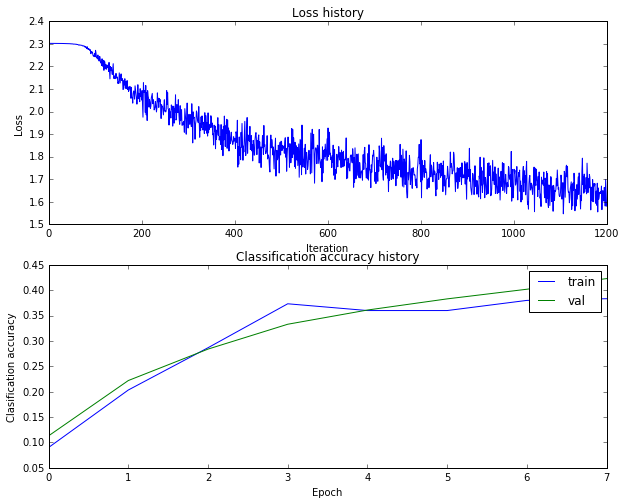


Run 1 -- Time: 20.2s Train: 0.417 Val: 0.425 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00029561  Reg: 0.01056643
That took 20.216310s
Accuracy:: Train: 0.417  Val: 0.425


Evolution - taking best with Accuracies Train: 0.417 Val: 0.425

Run 2 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00039664  Reg: 0.00199698
iteration 0 / 1201: loss 1.689443
iteration 100 / 1201: loss 1.508829
iteration 200 / 1201: loss 1.569279
iteration 300 / 1201: loss 1.596325
iteration 400 / 1201: loss 1.567877
iteration 500 / 1201: loss 1.482927
iteration 600 / 1201: loss 1.592333
iteration 700 / 1201: loss 1.515180
iteration 800 / 1201: loss 1.545796
iteration 900 / 1201: loss 1.511360
iteration 1000 / 1201: loss 1.516898
iteration 1100 / 1201: loss 1.448661
iteration 1200 / 1201: loss 1.420292


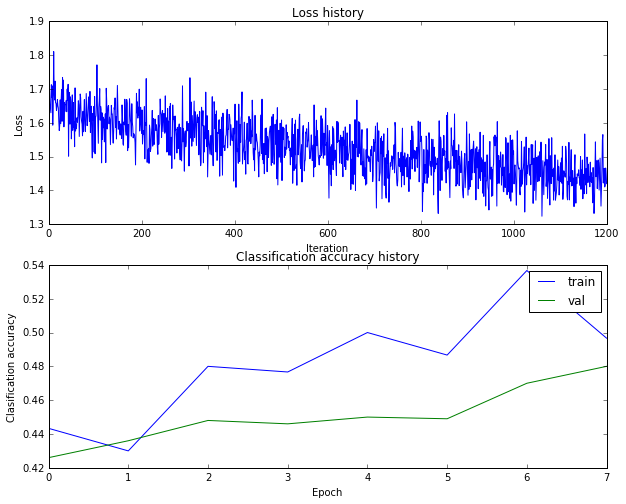


Run 2 -- Time: 22.4s Train: 0.498 Val: 0.487 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00039664  Reg: 0.00199698
That took 22.440730s
Accuracy:: Train: 0.498  Val: 0.487


Evolution - taking best with Accuracies Train: 0.498 Val: 0.487

Run 3 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00003339  Reg: 0.00001375
iteration 0 / 1201: loss 1.409634
iteration 100 / 1201: loss 1.424099
iteration 200 / 1201: loss 1.454319
iteration 300 / 1201: loss 1.386326
iteration 400 / 1201: loss 1.527283
iteration 500 / 1201: loss 1.354061
iteration 600 / 1201: loss 1.357990
iteration 700 / 1201: loss 1.526596
iteration 800 / 1201: loss 1.468901
iteration 900 / 1201: loss 1.399157
iteration 1000 / 1201: loss 1.466287
iteration 1100 / 1201: loss 1.397145
iteration 1200 / 1201: loss 1.436289


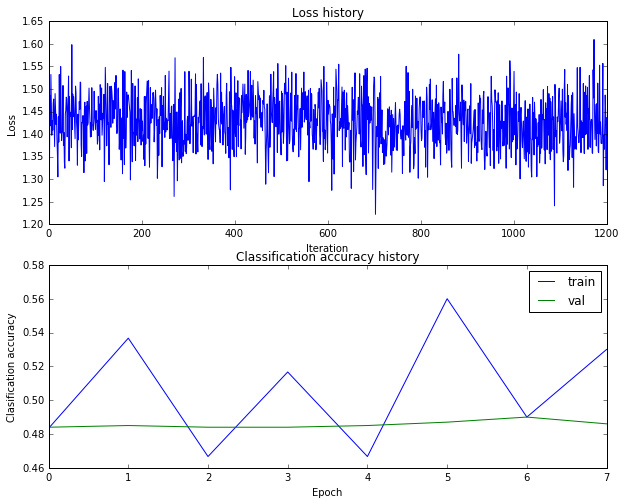


Run 3 -- Time: 21.1s Train: 0.505 Val: 0.485 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00003339  Reg: 0.00001375
That took 21.060401s
Accuracy:: Train: 0.505  Val: 0.485


Evolution - taking best with Accuracies Train: 0.498 Val: 0.487

Run 4 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00023022  Reg: 0.00076141
iteration 0 / 1201: loss 1.389472
iteration 100 / 1201: loss 1.407439
iteration 200 / 1201: loss 1.420139
iteration 300 / 1201: loss 1.441153
iteration 400 / 1201: loss 1.375243
iteration 500 / 1201: loss 1.511078
iteration 600 / 1201: loss 1.410111
iteration 700 / 1201: loss 1.480796
iteration 800 / 1201: loss 1.424329
iteration 900 / 1201: loss 1.491534
iteration 1000 / 1201: loss 1.222073
iteration 1100 / 1201: loss 1.375484
iteration 1200 / 1201: loss 1.397752


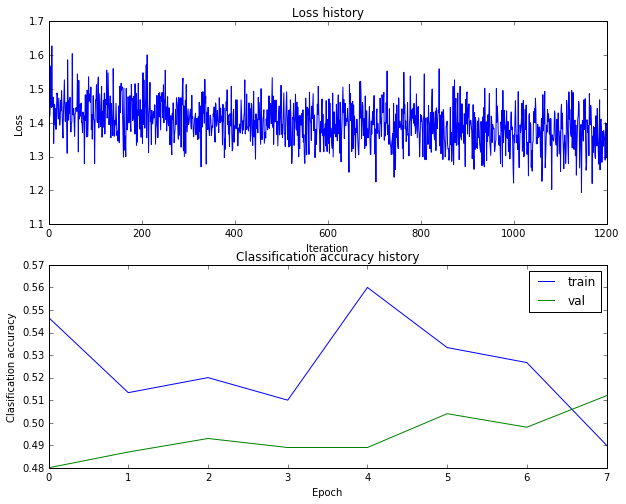


Run 4 -- Time: 23.6s Train: 0.524 Val: 0.505 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00023022  Reg: 0.00076141
That took 23.593056s
Accuracy:: Train: 0.524  Val: 0.505


Evolution - taking best with Accuracies Train: 0.524 Val: 0.505

Run 5 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00089675  Reg: 0.00012652
iteration 0 / 1201: loss 1.275288
iteration 100 / 1201: loss 1.396415
iteration 200 / 1201: loss 1.352243
iteration 300 / 1201: loss 1.297653
iteration 400 / 1201: loss 1.370394
iteration 500 / 1201: loss 1.346676
iteration 600 / 1201: loss 1.343410
iteration 700 / 1201: loss 1.250789
iteration 800 / 1201: loss 1.251078
iteration 900 / 1201: loss 1.238336
iteration 1000 / 1201: loss 1.324109
iteration 1100 / 1201: loss 1.183030
iteration 1200 / 1201: loss 1.290663


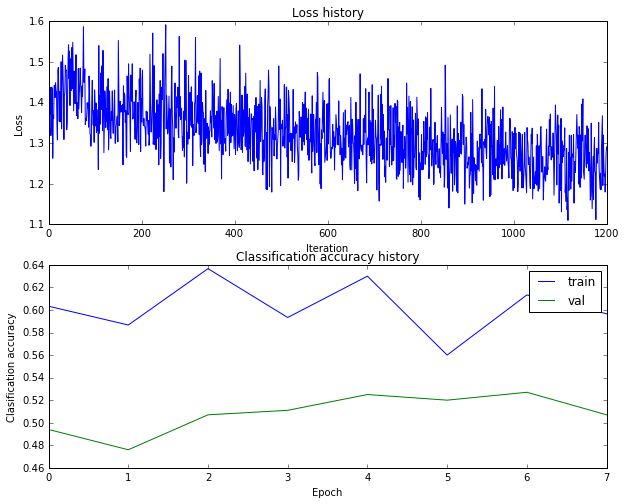


Run 5 -- Time: 19.0s Train: 0.568 Val: 0.522 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00089675  Reg: 0.00012652
That took 18.991774s
Accuracy:: Train: 0.568  Val: 0.522


Evolution - taking best with Accuracies Train: 0.568 Val: 0.522

Run 6 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00076210  Reg: 0.00004972
iteration 0 / 1201: loss 1.294144
iteration 100 / 1201: loss 1.288298
iteration 200 / 1201: loss 1.270635
iteration 300 / 1201: loss 1.205704
iteration 400 / 1201: loss 1.207815
iteration 500 / 1201: loss 1.261934
iteration 600 / 1201: loss 1.200506
iteration 700 / 1201: loss 1.239077
iteration 800 / 1201: loss 1.239132
iteration 900 / 1201: loss 1.224363
iteration 1000 / 1201: loss 1.156425
iteration 1100 / 1201: loss 1.269076
iteration 1200 / 1201: loss 1.122718


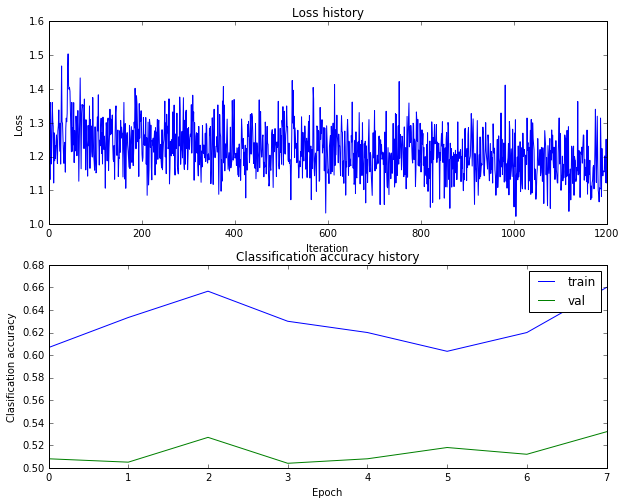


Run 6 -- Time: 25.4s Train: 0.593 Val: 0.522 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00076210  Reg: 0.00004972
That took 25.392715s
Accuracy:: Train: 0.593  Val: 0.522


Evolution - taking best with Accuracies Train: 0.568 Val: 0.522

Run 7 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00244766  Reg: 0.00070667
iteration 0 / 1201: loss 1.203103
iteration 100 / 1201: loss 1.377833
iteration 200 / 1201: loss 1.322402
iteration 300 / 1201: loss 1.202527
iteration 400 / 1201: loss 1.368838
iteration 500 / 1201: loss 1.437280
iteration 600 / 1201: loss 1.423151
iteration 700 / 1201: loss 1.413801
iteration 800 / 1201: loss 1.333290
iteration 900 / 1201: loss 1.306141
iteration 1000 / 1201: loss 1.246537
iteration 1100 / 1201: loss 1.414286
iteration 1200 / 1201: loss 1.324295


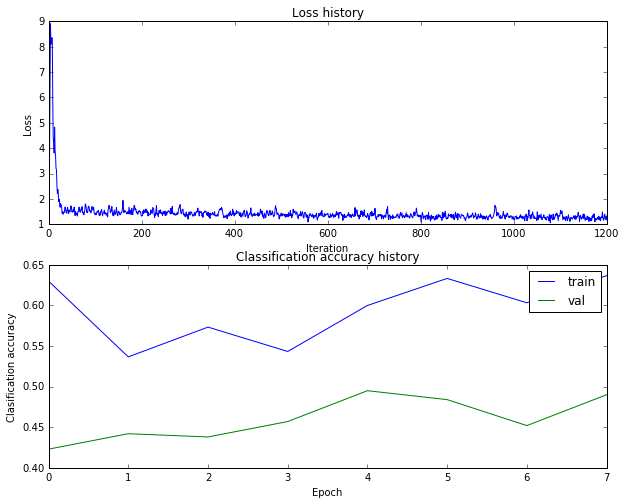


Run 7 -- Time: 20.7s Train: 0.556 Val: 0.500 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00244766  Reg: 0.00070667
That took 20.731917s
Accuracy:: Train: 0.556  Val: 0.5


Evolution - taking best with Accuracies Train: 0.568 Val: 0.522

Run 8 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00105147  Reg: 0.00006162
iteration 0 / 1201: loss 1.262256
iteration 100 / 1201: loss 1.386413
iteration 200 / 1201: loss 1.167875
iteration 300 / 1201: loss 1.371469
iteration 400 / 1201: loss 1.383249
iteration 500 / 1201: loss 1.337942
iteration 600 / 1201: loss 1.238878
iteration 700 / 1201: loss 1.256537
iteration 800 / 1201: loss 1.096670
iteration 900 / 1201: loss 1.221881
iteration 1000 / 1201: loss 1.210163
iteration 1100 / 1201: loss 1.126855
iteration 1200 / 1201: loss 1.220634


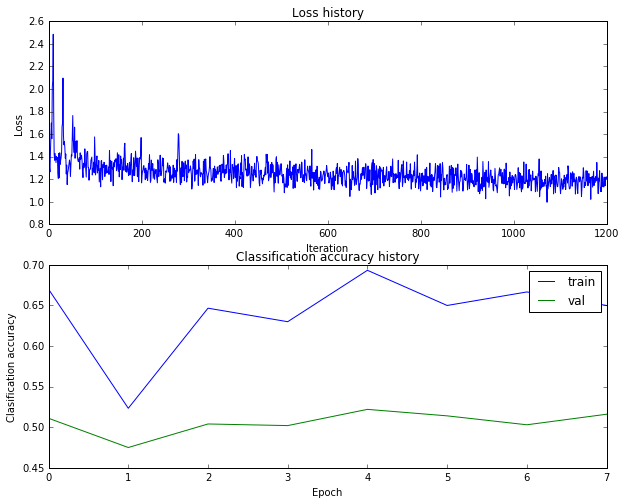


Run 8 -- Time: 19.9s Train: 0.592 Val: 0.521 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00105147  Reg: 0.00006162
That took 19.880220s
Accuracy:: Train: 0.592  Val: 0.521


Evolution - taking best with Accuracies Train: 0.568 Val: 0.522

Run 9 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00005541  Reg: 0.00001717
iteration 0 / 1201: loss 1.199564
iteration 100 / 1201: loss 1.239368
iteration 200 / 1201: loss 1.280203
iteration 300 / 1201: loss 1.236256
iteration 400 / 1201: loss 1.299874
iteration 500 / 1201: loss 1.179642
iteration 600 / 1201: loss 1.166520
iteration 700 / 1201: loss 1.181802
iteration 800 / 1201: loss 1.222083
iteration 900 / 1201: loss 1.160532
iteration 1000 / 1201: loss 1.296180
iteration 1100 / 1201: loss 1.184869
iteration 1200 / 1201: loss 1.232585


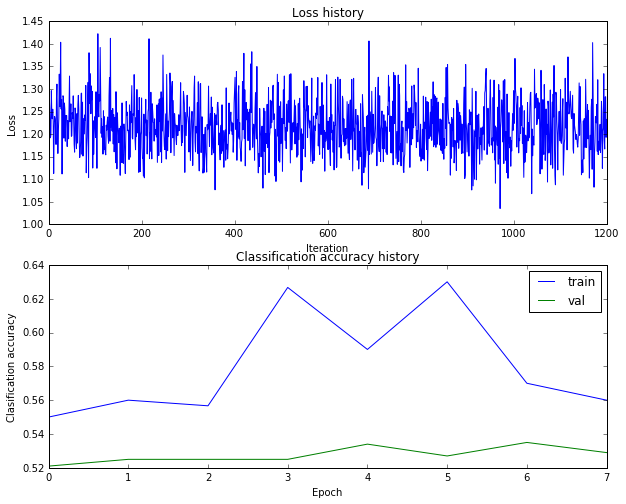


Run 9 -- Time: 19.0s Train: 0.587 Val: 0.530 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00005541  Reg: 0.00001717
That took 18.954607s
Accuracy:: Train: 0.587  Val: 0.53


Evolution - taking best with Accuracies Train: 0.587 Val: 0.530

Run 10 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00009981  Reg: 0.02056289
iteration 0 / 1201: loss 1.202054
iteration 100 / 1201: loss 1.046361
iteration 200 / 1201: loss 1.209944
iteration 300 / 1201: loss 1.170198
iteration 400 / 1201: loss 1.165038
iteration 500 / 1201: loss 1.071361
iteration 600 / 1201: loss 1.168907
iteration 700 / 1201: loss 1.189594
iteration 800 / 1201: loss 1.185292
iteration 900 / 1201: loss 1.137403
iteration 1000 / 1201: loss 1.227941
iteration 1100 / 1201: loss 1.109273
iteration 1200 / 1201: loss 1.236801


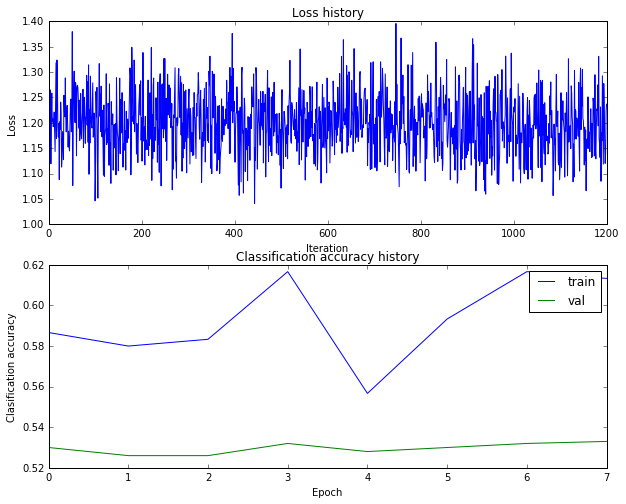


Run 10 -- Time: 18.4s Train: 0.591 Val: 0.536 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00009981  Reg: 0.02056289
That took 18.376454s
Accuracy:: Train: 0.591  Val: 0.536


Evolution - taking best with Accuracies Train: 0.591 Val: 0.536

Run 11 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00196537  Reg: 0.03539986
iteration 0 / 1201: loss 1.242938
iteration 100 / 1201: loss 1.335826
iteration 200 / 1201: loss 1.304034
iteration 300 / 1201: loss 1.283269
iteration 400 / 1201: loss 1.300388
iteration 500 / 1201: loss 1.293334
iteration 600 / 1201: loss 1.310942
iteration 700 / 1201: loss 1.393870
iteration 800 / 1201: loss 1.267512
iteration 900 / 1201: loss 1.313637
iteration 1000 / 1201: loss 1.183386
iteration 1100 / 1201: loss 1.290451
iteration 1200 / 1201: loss 1.298320


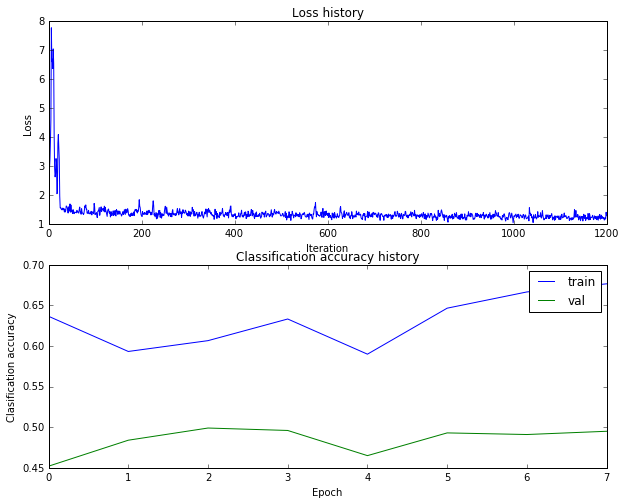


Run 11 -- Time: 21.5s Train: 0.573 Val: 0.499 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00196537  Reg: 0.03539986
That took 21.507202s
Accuracy:: Train: 0.573  Val: 0.499


Evolution - taking best with Accuracies Train: 0.591 Val: 0.536

Run 12 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00014448  Reg: 0.00015426
iteration 0 / 1201: loss 1.128217
iteration 100 / 1201: loss 1.130971
iteration 200 / 1201: loss 1.260107
iteration 300 / 1201: loss 1.068717
iteration 400 / 1201: loss 1.235754
iteration 500 / 1201: loss 1.274420
iteration 600 / 1201: loss 1.225912
iteration 700 / 1201: loss 1.185745
iteration 800 / 1201: loss 1.197425
iteration 900 / 1201: loss 1.139975
iteration 1000 / 1201: loss 1.186650
iteration 1100 / 1201: loss 1.115576
iteration 1200 / 1201: loss 1.095842


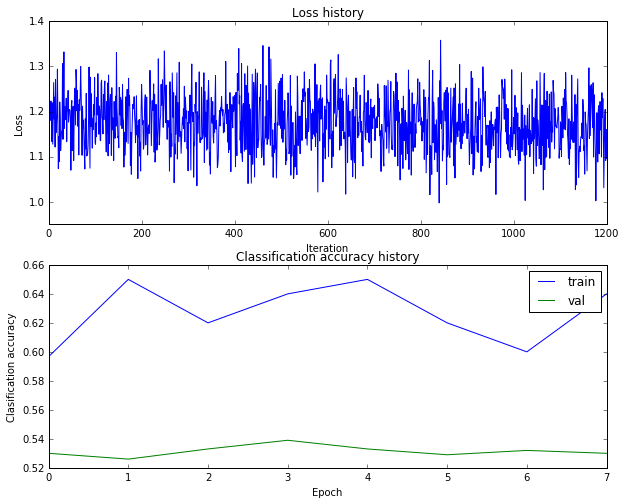


Run 12 -- Time: 20.7s Train: 0.599 Val: 0.538 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00014448  Reg: 0.00015426
That took 20.668168s
Accuracy:: Train: 0.599  Val: 0.538


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 13 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00071799  Reg: 0.05141395
iteration 0 / 1201: loss 1.099418
iteration 100 / 1201: loss 1.299443
iteration 200 / 1201: loss 1.205630
iteration 300 / 1201: loss 1.252898
iteration 400 / 1201: loss 1.226202
iteration 500 / 1201: loss 1.089516
iteration 600 / 1201: loss 1.240065
iteration 700 / 1201: loss 1.286545
iteration 800 / 1201: loss 1.342844
iteration 900 / 1201: loss 1.089194
iteration 1000 / 1201: loss 1.169223
iteration 1100 / 1201: loss 1.202756
iteration 1200 / 1201: loss 1.193327


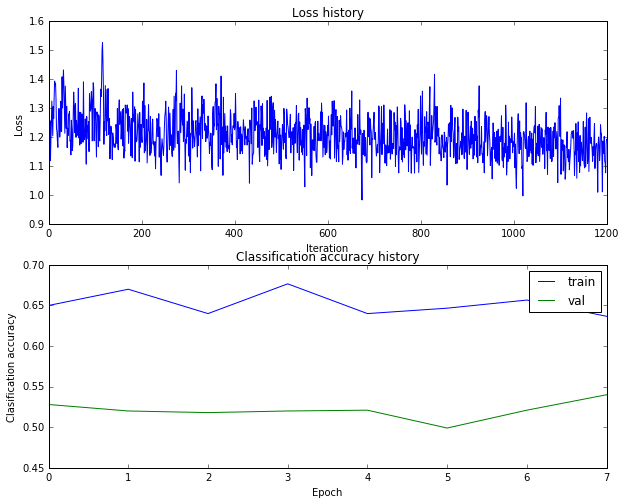


Run 13 -- Time: 18.9s Train: 0.608 Val: 0.531 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00071799  Reg: 0.05141395
That took 18.946568s
Accuracy:: Train: 0.608  Val: 0.531


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 14 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00132626  Reg: 0.00314945
iteration 0 / 1201: loss 1.209868
iteration 100 / 1201: loss 1.384373
iteration 200 / 1201: loss 1.303819
iteration 300 / 1201: loss 1.289179
iteration 400 / 1201: loss 1.166771
iteration 500 / 1201: loss 1.236551
iteration 600 / 1201: loss 1.238264
iteration 700 / 1201: loss 1.331876
iteration 800 / 1201: loss 1.198924
iteration 900 / 1201: loss 1.132685
iteration 1000 / 1201: loss 1.028815
iteration 1100 / 1201: loss 1.281264
iteration 1200 / 1201: loss 1.091706


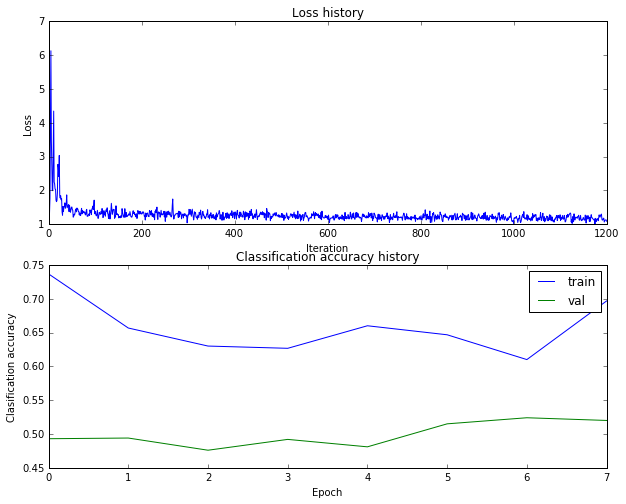


Run 14 -- Time: 20.1s Train: 0.596 Val: 0.517 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00132626  Reg: 0.00314945
That took 20.138744s
Accuracy:: Train: 0.596  Val: 0.517


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 15 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00182019  Reg: 0.01402131
iteration 0 / 1201: loss 1.218836
iteration 100 / 1201: loss 1.415039
iteration 200 / 1201: loss 1.312750
iteration 300 / 1201: loss 1.398133
iteration 400 / 1201: loss 1.474073
iteration 500 / 1201: loss 1.291608
iteration 600 / 1201: loss 1.246598
iteration 700 / 1201: loss 1.230158
iteration 800 / 1201: loss 1.259033
iteration 900 / 1201: loss 1.119809
iteration 1000 / 1201: loss 1.172022
iteration 1100 / 1201: loss 1.236022
iteration 1200 / 1201: loss 1.151642


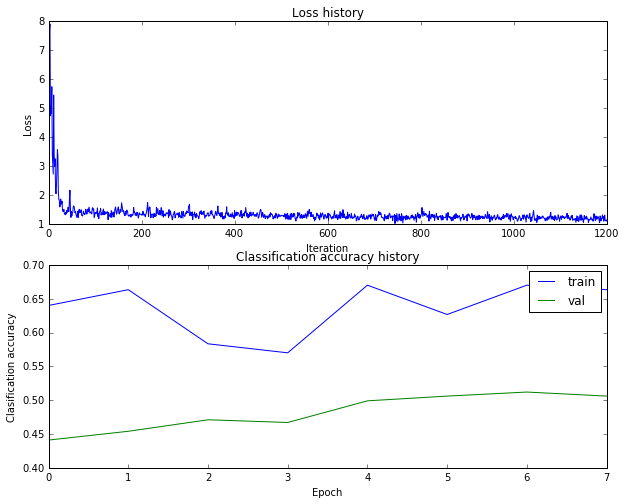


Run 15 -- Time: 18.9s Train: 0.585 Val: 0.490 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00182019  Reg: 0.01402131
That took 18.907220s
Accuracy:: Train: 0.585  Val: 0.49


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 16 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00005088  Reg: 0.09261825
iteration 0 / 1201: loss 1.154864
iteration 100 / 1201: loss 1.187050
iteration 200 / 1201: loss 1.183665
iteration 300 / 1201: loss 1.172240
iteration 400 / 1201: loss 1.181737
iteration 500 / 1201: loss 1.167885
iteration 600 / 1201: loss 1.208890
iteration 700 / 1201: loss 1.292644
iteration 800 / 1201: loss 1.152324
iteration 900 / 1201: loss 1.187094
iteration 1000 / 1201: loss 1.205092
iteration 1100 / 1201: loss 1.100886
iteration 1200 / 1201: loss 1.187989


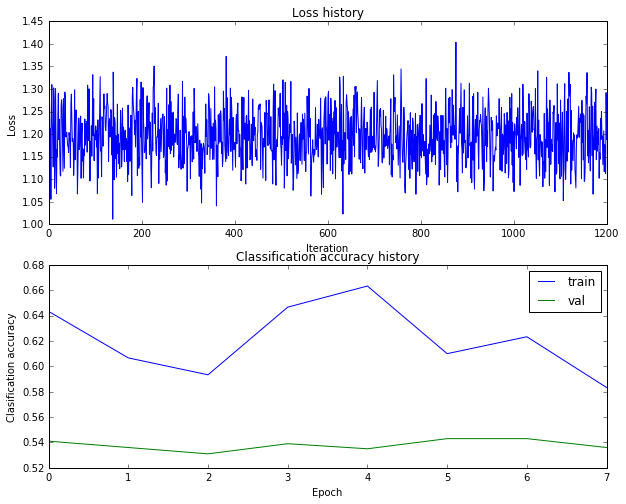


Run 16 -- Time: 20.5s Train: 0.604 Val: 0.536 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00005088  Reg: 0.09261825
That took 20.531049s
Accuracy:: Train: 0.604  Val: 0.536


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 17 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00025178  Reg: 0.00008051
iteration 0 / 1201: loss 1.192730
iteration 100 / 1201: loss 1.179098
iteration 200 / 1201: loss 1.140356
iteration 300 / 1201: loss 1.204324
iteration 400 / 1201: loss 1.122249
iteration 500 / 1201: loss 1.175636
iteration 600 / 1201: loss 1.138606
iteration 700 / 1201: loss 1.052372
iteration 800 / 1201: loss 1.174735
iteration 900 / 1201: loss 1.103696
iteration 1000 / 1201: loss 1.173165
iteration 1100 / 1201: loss 1.159551
iteration 1200 / 1201: loss 1.161695


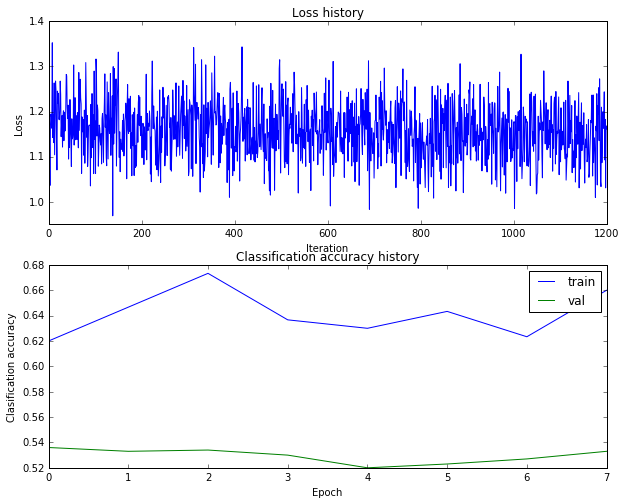


Run 17 -- Time: 23.7s Train: 0.608 Val: 0.529 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00025178  Reg: 0.00008051
That took 23.703889s
Accuracy:: Train: 0.608  Val: 0.529


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 18 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00182418  Reg: 0.00401803
iteration 0 / 1201: loss 1.194273
iteration 100 / 1201: loss 1.536621
iteration 200 / 1201: loss 1.367301
iteration 300 / 1201: loss 1.381075
iteration 400 / 1201: loss 1.375698
iteration 500 / 1201: loss 1.343656
iteration 600 / 1201: loss 1.256054
iteration 700 / 1201: loss 1.261597
iteration 800 / 1201: loss 1.172392
iteration 900 / 1201: loss 1.325595
iteration 1000 / 1201: loss 1.317855
iteration 1100 / 1201: loss 1.331108
iteration 1200 / 1201: loss 1.192072


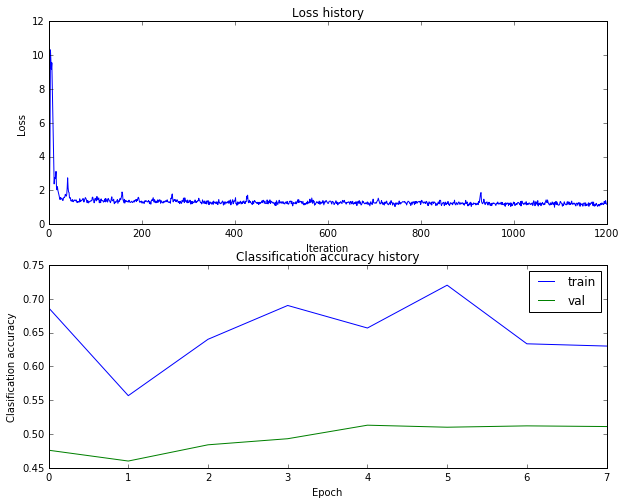


Run 18 -- Time: 30.6s Train: 0.584 Val: 0.509 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00182418  Reg: 0.00401803
That took 30.621978s
Accuracy:: Train: 0.584  Val: 0.509


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 19 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00018958  Reg: 0.00120875
iteration 0 / 1201: loss 1.111329
iteration 100 / 1201: loss 1.175607
iteration 200 / 1201: loss 1.028289
iteration 300 / 1201: loss 1.146586
iteration 400 / 1201: loss 1.183825
iteration 500 / 1201: loss 1.235158
iteration 600 / 1201: loss 1.070866
iteration 700 / 1201: loss 1.179181
iteration 800 / 1201: loss 1.201501
iteration 900 / 1201: loss 1.138518
iteration 1000 / 1201: loss 1.207743
iteration 1100 / 1201: loss 1.178687
iteration 1200 / 1201: loss 1.159348


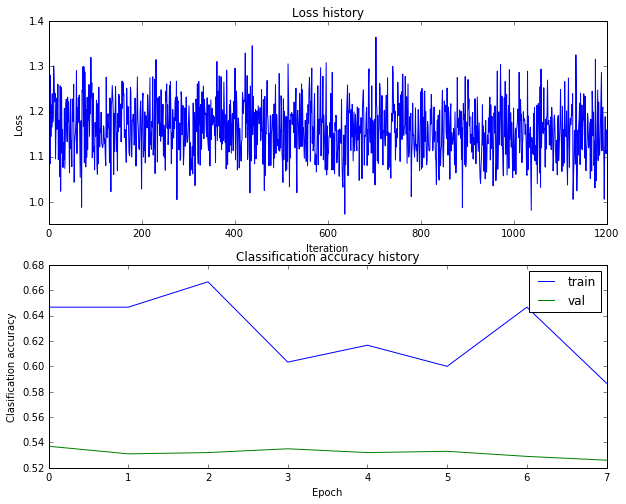


Run 19 -- Time: 30.1s Train: 0.606 Val: 0.524 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00018958  Reg: 0.00120875
That took 30.131126s
Accuracy:: Train: 0.606  Val: 0.524


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 20 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00098281  Reg: 0.09475940
iteration 0 / 1201: loss 1.191097
iteration 100 / 1201: loss 1.222688
iteration 200 / 1201: loss 1.366960
iteration 300 / 1201: loss 1.162919
iteration 400 / 1201: loss 1.271380
iteration 500 / 1201: loss 1.246784
iteration 600 / 1201: loss 1.227974
iteration 700 / 1201: loss 1.371035
iteration 800 / 1201: loss 1.282392
iteration 900 / 1201: loss 1.269989
iteration 1000 / 1201: loss 1.295638
iteration 1100 / 1201: loss 1.225411
iteration 1200 / 1201: loss 1.237433


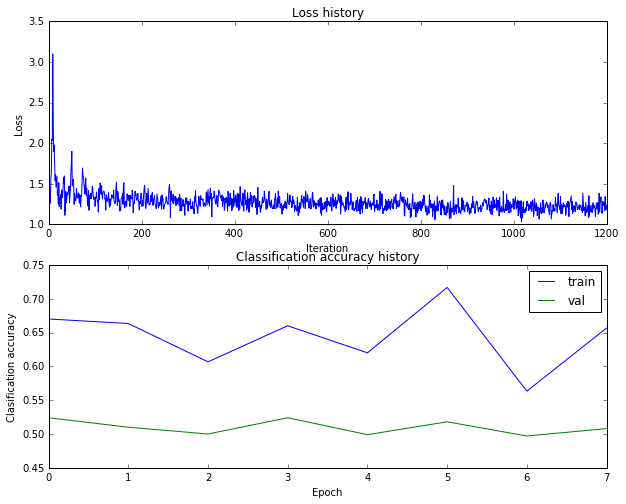


Run 20 -- Time: 29.7s Train: 0.597 Val: 0.526 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00098281  Reg: 0.09475940
That took 29.692361s
Accuracy:: Train: 0.597  Val: 0.526


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 21 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00162160  Reg: 0.07418892
iteration 0 / 1201: loss 1.165368
iteration 100 / 1201: loss 1.425316
iteration 200 / 1201: loss 1.422199
iteration 300 / 1201: loss 1.314992
iteration 400 / 1201: loss 1.278206
iteration 500 / 1201: loss 1.242433
iteration 600 / 1201: loss 1.324149
iteration 700 / 1201: loss 1.182139
iteration 800 / 1201: loss 1.274461
iteration 900 / 1201: loss 1.259151
iteration 1000 / 1201: loss 1.246763
iteration 1100 / 1201: loss 1.200745
iteration 1200 / 1201: loss 1.080811


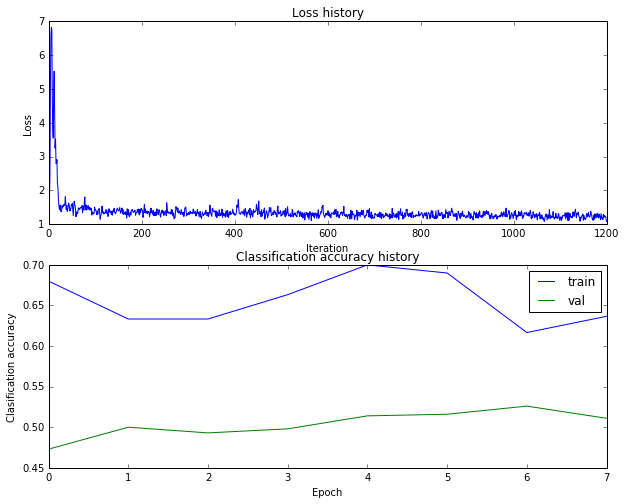


Run 21 -- Time: 25.9s Train: 0.588 Val: 0.512 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00162160  Reg: 0.07418892
That took 25.908219s
Accuracy:: Train: 0.588  Val: 0.512


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 22 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00102189  Reg: 0.00066080
iteration 0 / 1201: loss 1.131005
iteration 100 / 1201: loss 1.243624
iteration 200 / 1201: loss 1.070126
iteration 300 / 1201: loss 1.202023
iteration 400 / 1201: loss 1.303318
iteration 500 / 1201: loss 1.237040
iteration 600 / 1201: loss 1.183371
iteration 700 / 1201: loss 1.251206
iteration 800 / 1201: loss 1.310350
iteration 900 / 1201: loss 1.186281
iteration 1000 / 1201: loss 1.121540
iteration 1100 / 1201: loss 1.222443
iteration 1200 / 1201: loss 1.136767


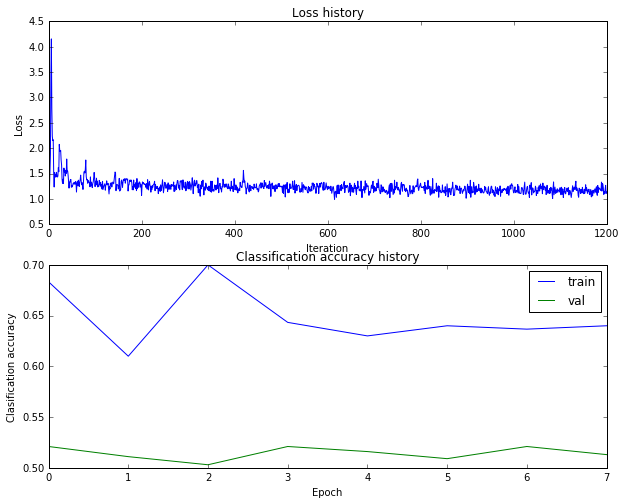


Run 22 -- Time: 23.5s Train: 0.605 Val: 0.517 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00102189  Reg: 0.00066080
That took 23.520083s
Accuracy:: Train: 0.605  Val: 0.517


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 23 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00014221  Reg: 0.00136926
iteration 0 / 1201: loss 1.141023
iteration 100 / 1201: loss 1.202080
iteration 200 / 1201: loss 1.124722
iteration 300 / 1201: loss 1.065264
iteration 400 / 1201: loss 1.259101
iteration 500 / 1201: loss 1.199145
iteration 600 / 1201: loss 1.235257
iteration 700 / 1201: loss 1.176354
iteration 800 / 1201: loss 1.184920
iteration 900 / 1201: loss 1.251744
iteration 1000 / 1201: loss 1.191282
iteration 1100 / 1201: loss 1.127206
iteration 1200 / 1201: loss 1.066964


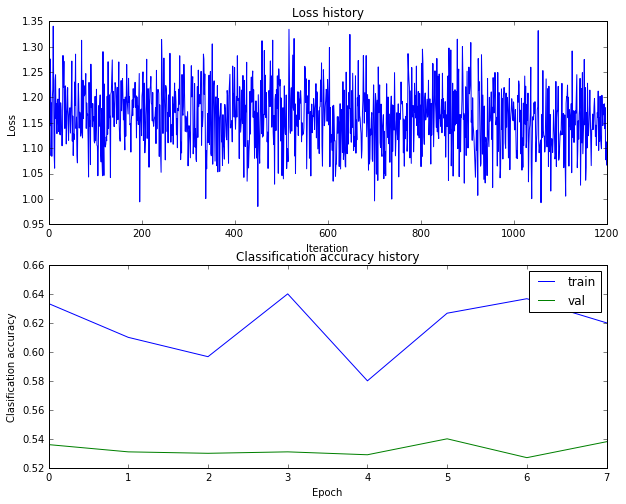


Run 23 -- Time: 19.1s Train: 0.604 Val: 0.535 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00014221  Reg: 0.00136926
That took 19.112363s
Accuracy:: Train: 0.604  Val: 0.535


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 24 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00021042  Reg: 0.02723595
iteration 0 / 1201: loss 1.228199
iteration 100 / 1201: loss 1.140424
iteration 200 / 1201: loss 1.224907
iteration 300 / 1201: loss 1.171728
iteration 400 / 1201: loss 1.126574
iteration 500 / 1201: loss 1.257027
iteration 600 / 1201: loss 1.218663
iteration 700 / 1201: loss 1.263325
iteration 800 / 1201: loss 1.200868
iteration 900 / 1201: loss 1.235995
iteration 1000 / 1201: loss 1.165939
iteration 1100 / 1201: loss 1.082878
iteration 1200 / 1201: loss 1.236561


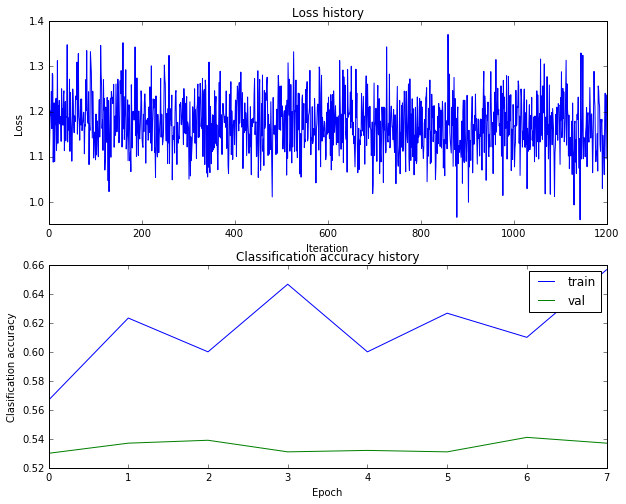


Run 24 -- Time: 19.2s Train: 0.609 Val: 0.528 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00021042  Reg: 0.02723595
That took 19.230344s
Accuracy:: Train: 0.609  Val: 0.528


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 25 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00015756  Reg: 0.02351340
iteration 0 / 1201: loss 1.200394
iteration 100 / 1201: loss 1.140428
iteration 200 / 1201: loss 1.177887
iteration 300 / 1201: loss 1.202628
iteration 400 / 1201: loss 1.173722
iteration 500 / 1201: loss 1.178111
iteration 600 / 1201: loss 1.255259
iteration 700 / 1201: loss 1.138938
iteration 800 / 1201: loss 1.186115
iteration 900 / 1201: loss 1.053335
iteration 1000 / 1201: loss 1.168454
iteration 1100 / 1201: loss 1.141258
iteration 1200 / 1201: loss 1.135890


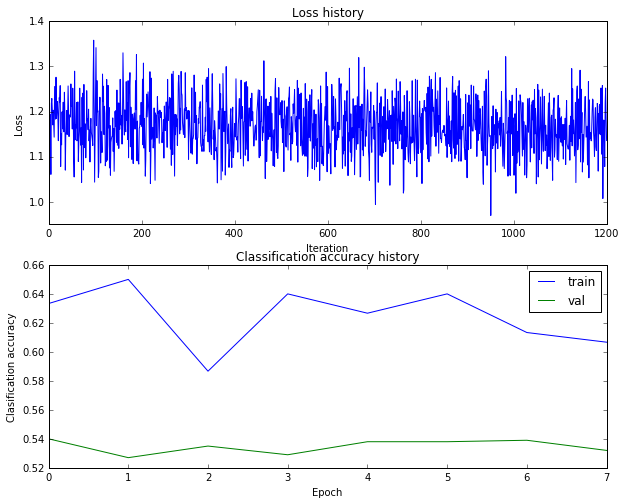


Run 25 -- Time: 19.6s Train: 0.607 Val: 0.533 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00015756  Reg: 0.02351340
That took 19.571324s
Accuracy:: Train: 0.607  Val: 0.533


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 26 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00003649  Reg: 0.00004614
iteration 0 / 1201: loss 1.188187
iteration 100 / 1201: loss 1.081291
iteration 200 / 1201: loss 1.151537
iteration 300 / 1201: loss 1.183879
iteration 400 / 1201: loss 1.149460
iteration 500 / 1201: loss 1.140820
iteration 600 / 1201: loss 1.259844
iteration 700 / 1201: loss 1.231348
iteration 800 / 1201: loss 1.070763
iteration 900 / 1201: loss 1.189998
iteration 1000 / 1201: loss 1.173794
iteration 1100 / 1201: loss 1.117579
iteration 1200 / 1201: loss 1.098994


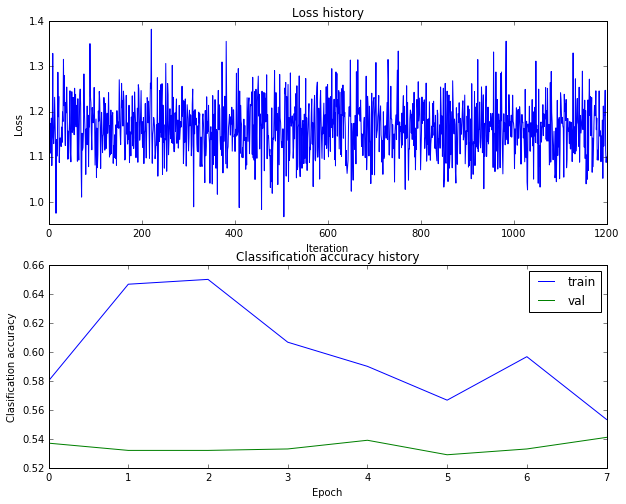


Run 26 -- Time: 19.7s Train: 0.603 Val: 0.537 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00003649  Reg: 0.00004614
That took 19.747553s
Accuracy:: Train: 0.603  Val: 0.537


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 27 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00009656  Reg: 0.01274805
iteration 0 / 1201: loss 1.165538
iteration 100 / 1201: loss 1.221807
iteration 200 / 1201: loss 1.187657
iteration 300 / 1201: loss 1.267242
iteration 400 / 1201: loss 1.145987
iteration 500 / 1201: loss 1.272280
iteration 600 / 1201: loss 1.159905
iteration 700 / 1201: loss 1.117053
iteration 800 / 1201: loss 1.194932
iteration 900 / 1201: loss 1.151746
iteration 1000 / 1201: loss 1.121489
iteration 1100 / 1201: loss 1.197664
iteration 1200 / 1201: loss 1.117991


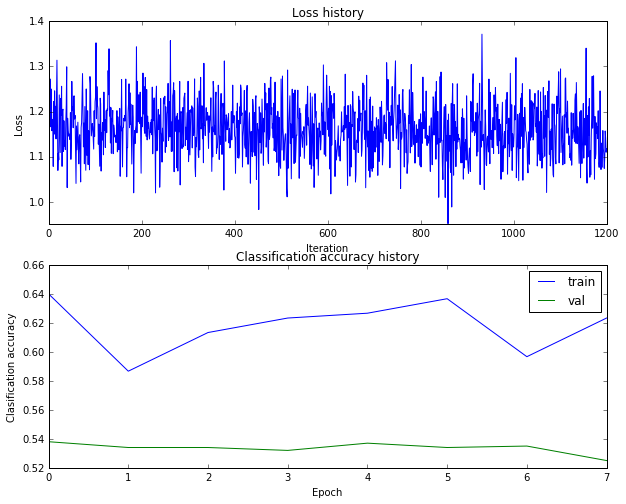


Run 27 -- Time: 18.6s Train: 0.603 Val: 0.531 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00009656  Reg: 0.01274805
That took 18.558937s
Accuracy:: Train: 0.603  Val: 0.531


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 28 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00150877  Reg: 0.00135093
iteration 0 / 1201: loss 1.058893
iteration 100 / 1201: loss 1.324054
iteration 200 / 1201: loss 1.241329
iteration 300 / 1201: loss 1.434491
iteration 400 / 1201: loss 1.450018
iteration 500 / 1201: loss 1.235925
iteration 600 / 1201: loss 1.240266
iteration 700 / 1201: loss 1.186806
iteration 800 / 1201: loss 1.233834
iteration 900 / 1201: loss 1.259776
iteration 1000 / 1201: loss 1.095449
iteration 1100 / 1201: loss 1.215517
iteration 1200 / 1201: loss 1.182650


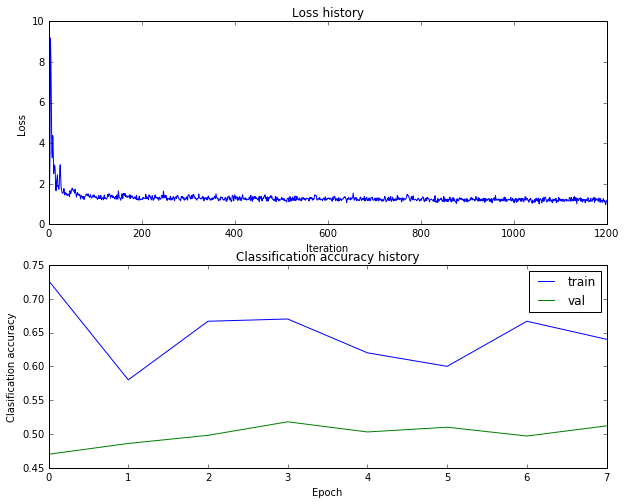


Run 28 -- Time: 18.1s Train: 0.584 Val: 0.506 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00150877  Reg: 0.00135093
That took 18.093179s
Accuracy:: Train: 0.584  Val: 0.506


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 29 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00016382  Reg: 0.00433269
iteration 0 / 1201: loss 1.222150
iteration 100 / 1201: loss 1.154304
iteration 200 / 1201: loss 1.216015
iteration 300 / 1201: loss 1.180849
iteration 400 / 1201: loss 1.210470
iteration 500 / 1201: loss 1.202708
iteration 600 / 1201: loss 1.193434
iteration 700 / 1201: loss 1.187728
iteration 800 / 1201: loss 1.063823
iteration 900 / 1201: loss 1.088530
iteration 1000 / 1201: loss 1.182719
iteration 1100 / 1201: loss 1.161490
iteration 1200 / 1201: loss 1.116079


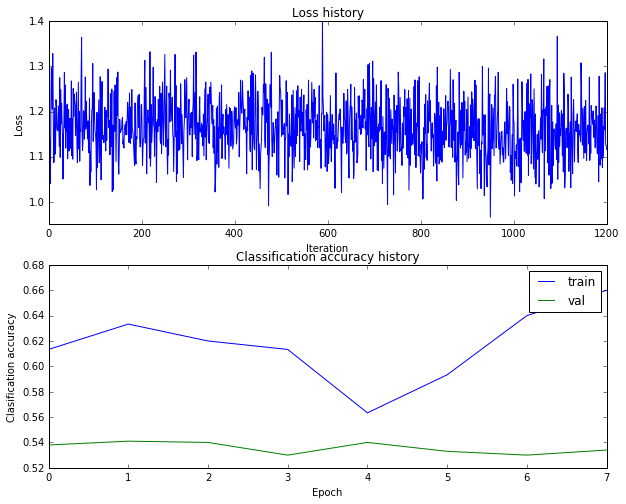


Run 29 -- Time: 19.5s Train: 0.607 Val: 0.533 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00016382  Reg: 0.00433269
That took 19.463406s
Accuracy:: Train: 0.607  Val: 0.533


Evolution - taking best with Accuracies Train: 0.599 Val: 0.538

Run 30 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00101251  Reg: 0.00820325
iteration 0 / 1201: loss 1.254281
iteration 100 / 1201: loss 1.332885
iteration 200 / 1201: loss 1.416647
iteration 300 / 1201: loss 1.368282
iteration 400 / 1201: loss 1.246781
iteration 500 / 1201: loss 1.127102
iteration 600 / 1201: loss 1.187982
iteration 700 / 1201: loss 1.071974
iteration 800 / 1201: loss 1.118404
iteration 900 / 1201: loss 1.264869
iteration 1000 / 1201: loss 1.234711
iteration 1100 / 1201: loss 1.071858
iteration 1200 / 1201: loss 1.275856


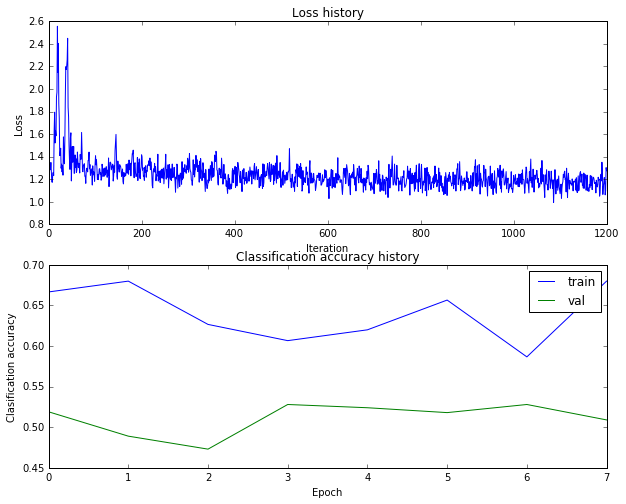


Run 30 -- Time: 25.0s Train: 0.594 Val: 0.515 -- HS: 60 #iter: 1201 #batch: 300 LR: 0.00101251  Reg: 0.00820325
That took 25.044528s
Accuracy:: Train: 0.594  Val: 0.515

Final Evaluations
HS: 60 #iter: 1201 #batch: 300 LR: 0.00009656  Reg: 0.01274805 ACC Test: 0.603 Val: 0.531 Test 0.521
HS: 60 #iter: 1201 #batch: 300 LR: 0.00105147  Reg: 0.00006162 ACC Test: 0.592 Val: 0.521 Test 0.502
HS: 60 #iter: 1201 #batch: 300 LR: 0.00076210  Reg: 0.00004972 ACC Test: 0.593 Val: 0.522 Test 0.506
HS: 60 #iter: 1201 #batch: 300 LR: 0.00162160  Reg: 0.07418892 ACC Test: 0.588 Val: 0.512 Test 0.493
HS: 60 #iter: 1201 #batch: 300 LR: 0.00098281  Reg: 0.09475940 ACC Test: 0.597 Val: 0.526 Test 0.490
HS: 60 #iter: 1201 #batch: 300 LR: 0.00003339  Reg: 0.00001375 ACC Test: 0.505 Val: 0.485 Test 0.480
HS: 60 #iter: 1201 #batch: 300 LR: 0.00071799  Reg: 0.05141395 ACC Test: 0.608 Val: 0.531 Test 0.500
HS: 60 #iter: 1201 #batch: 300 LR: 0.00018958  Reg: 0.00120875 ACC Test: 0.606 Val: 0.524 Test 0.513
HS:

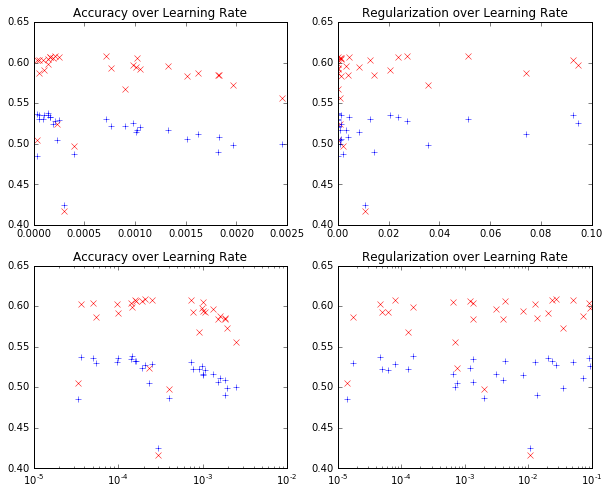

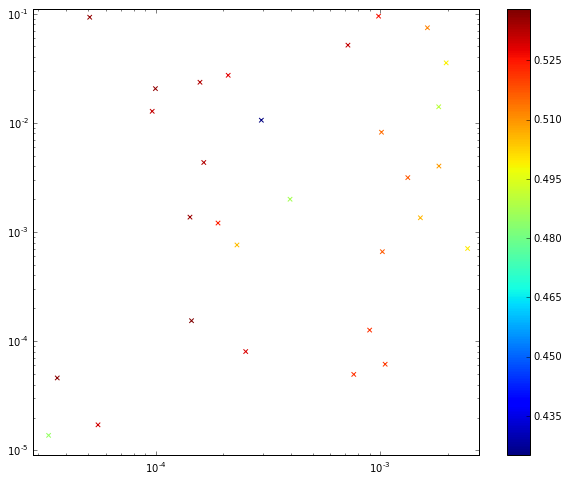

In [162]:
with_evolution = True
best_net = None # store the best model into this 
best_stats = None 
best_val = None
input_size = 32 * 32 * 3
num_classes = 10
results = {}

n_runs = 30
num_iters = 1201
batch_size = 300
learning_rate_decay = 0.95
hidden_size = 50
hidden_size = 60
net = TwoLayerNet(input_size, hidden_size, num_classes)

lr_ranges_exp = np.array([-4.5,-2.6])
reg_ranges_exp = np.array([-5,-1])


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
#for lr in np.linspace(learning_rates[0], learning_rates[1], 4):
#    for reg in np.linspace(regularization_strengths[0], regularization_strengths[1], 4):
for run in xrange(n_runs):
    lr = 10**np.random.uniform(*lr_ranges_exp)
    reg = 10**np.random.uniform(*reg_ranges_exp)
    params = (hidden_size, num_iters, batch_size, lr, reg)
    hidden_size, num_iters, batch_size, lr, reg = params        
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    if with_evolution and best_net is not None:
        print "\n\nEvolution - taking best with Accuracies Train: {:.3f} Val: {:.3f}".format(
        best_acc_train, best_val)
        net.params['W1'] = best_net.params['W1'] * (1+np.random.randn(input_size, hidden_size) * 1e-8)
        net.params['b1'] = best_net.params['b1'] * (1+np.random.randn(hidden_size) * 1e-8)
        net.params['W2'] = best_net.params['W2'] * (1+np.random.randn(hidden_size, num_classes) * 1e-8)
        net.params['b2'] = best_net.params['b2'] * (1+np.random.randn(num_classes) * 1e-8)

        
    print "\nRun {} -- HS: {} #iter: {} #batch: {} LR: {:.8f}  Reg: {:.8f}".format(run+1, *params)
    # Train the network
    tic = time.time()
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=num_iters, batch_size=batch_size,
            learning_rate=lr, learning_rate_decay=learning_rate_decay,
            reg=reg, verbose=True)
    acc_train = eval_acc(net, X_train, y_train)
    acc_val = eval_acc(net, X_val, y_val)
    acc_test = eval_acc(net, X_test, y_test)
    toc = time.time()
    results[params] = [acc_train, acc_val, acc_test, stats, params, net]
    show_stats_history(stats)
    
    print "\nRun {} -- Time: {:.1f}s Train: {:.3} Val: {:.3f} -- HS: {} #iter: {} #batch: {} LR: {:.8f}  Reg: {:.8f}".format(
        run+1, toc-tic, acc_train, acc_val, *params)
    print 'That took %fs' % (toc - tic)
    print 'Accuracy:: Train: {:.3}  Val: {:.3}'.format(acc_train, acc_val)
    if best_val < acc_val:
        best_val = acc_val
        best_acc_train = acc_train
        best_net = net
        best_stats = stats
        best_run = run
        best_params = params
        

show_results(results, best_params, lr_ranges=lr_ranges_exp, reg_ranges=reg_ranges_exp)    

In [ ]:
show_results(results, best_params, lr_ranges=lr_ranges_exp, reg_ranges=reg_ranges_exp)


Final Evaluations
HS: 65 #iter: 1201 #batch: 200 LR: 0.00180417  Reg: 0.00065372 ACC Test: 0.543 Val:  0.49 Test 0.495
HS: 65 #iter: 1201 #batch: 200 LR: 0.00012548  Reg: 0.00207711 ACC Test: 0.613 Val: 0.537 Test 0.524
HS: 65 #iter: 1201 #batch: 200 LR: 0.00003547  Reg: 0.00027485 ACC Test: 0.611 Val: 0.532 Test 0.529
HS: 65 #iter: 1201 #batch: 200 LR: 0.00171658  Reg: 0.02594799 ACC Test: 0.585 Val: 0.474 Test 0.511
HS: 65 #iter: 1201 #batch: 200 LR: 0.00006837  Reg: 0.00242077 ACC Test: 0.612 Val:  0.54 Test 0.525
HS: 65 #iter: 1201 #batch: 200 LR: 0.00007748  Reg: 0.00049068 ACC Test: 0.276 Val: 0.282 Test 0.284
HS: 65 #iter: 1201 #batch: 200 LR: 0.00009963  Reg: 0.00005363 ACC Test: 0.612 Val: 0.527 Test 0.530
HS: 65 #iter: 1201 #batch: 200 LR: 0.00007468  Reg: 0.00017101 ACC Test: 0.612 Val: 0.517 Test 0.524
HS: 65 #iter: 1201 #batch: 200 LR: 0.00012074  Reg: 0.00008687 ACC Test: 0.382 Val: 0.382 Test 0.371
HS: 65 #iter: 1201 #batch: 200 LR: 0.00012413  Reg: 0.00006080 ACC Test:

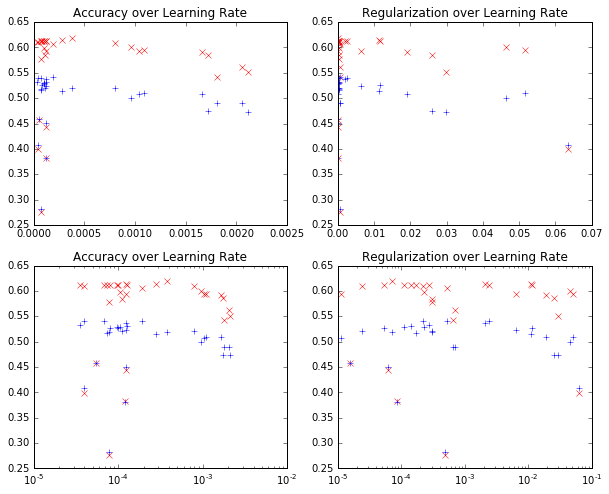

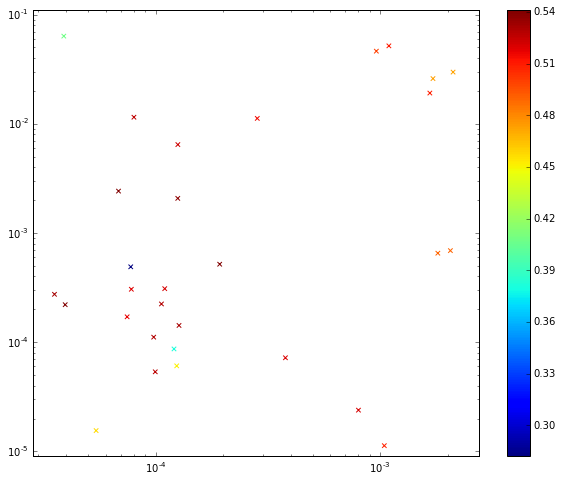

In [161]:
show_results(results, best_params, lr_ranges=lr_ranges_exp, reg_ranges=reg_ranges_exp)


Final Evaluations
HS: 75 #iter: 1001 #batch: 200 LR: 0.00014095  Reg: 0.00011928 ACC Test: 0.365 Val: 0.378 Test 0.371
HS: 75 #iter: 1001 #batch: 200 LR: 0.00084600  Reg: 0.09109491 ACC Test: 0.535 Val: 0.489 Test 0.481
HS: 75 #iter: 1001 #batch: 200 LR: 0.00094377  Reg: 0.00215957 ACC Test:  0.57 Val: 0.498 Test 0.495
HS: 75 #iter: 1001 #batch: 200 LR: 0.00022012  Reg: 0.00022586 ACC Test: 0.444 Val: 0.446 Test 0.429
HS: 75 #iter: 1001 #batch: 200 LR: 0.00022381  Reg: 0.00126192 ACC Test: 0.491 Val: 0.476 Test 0.473
HS: 75 #iter: 1001 #batch: 200 LR: 0.00031798  Reg: 0.06460651 ACC Test: 0.627 Val: 0.529 Test 0.508
HS: 75 #iter: 1001 #batch: 200 LR: 0.00004865  Reg: 0.00001635 ACC Test: 0.456 Val: 0.461 Test 0.440
HS: 75 #iter: 1001 #batch: 200 LR: 0.00008719  Reg: 0.07239003 ACC Test: 0.504 Val: 0.478 Test 0.489
HS: 75 #iter: 1001 #batch: 200 LR: 0.00004948  Reg: 0.01875224 ACC Test: 0.212 Val: 0.229 Test 0.233
HS: 75 #iter: 1001 #batch: 200 LR: 0.00062233  Reg: 0.00412466 ACC Test:

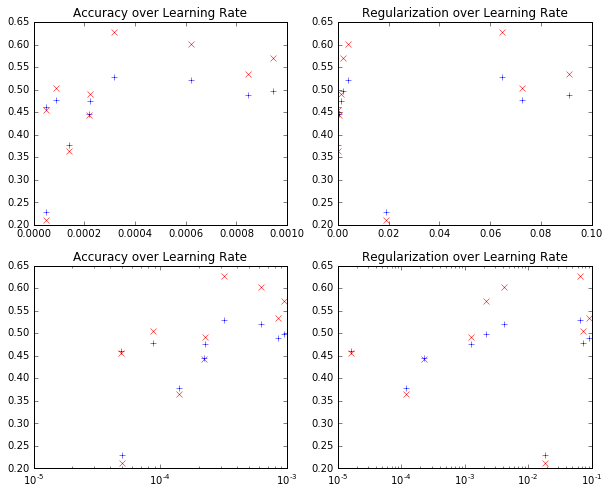

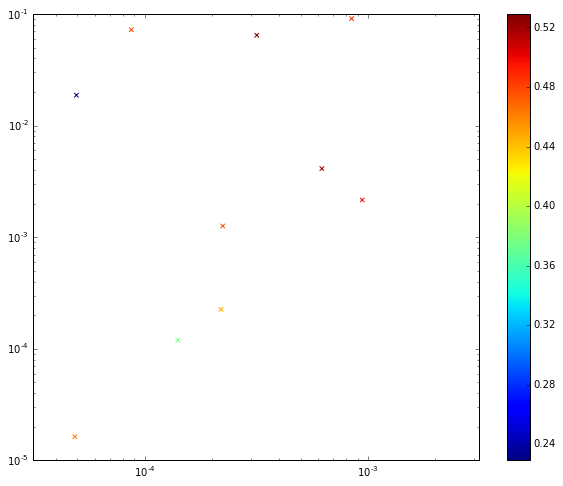

In [135]:
show_results(results, best_params, lr_ranges=lr_ranges_exp, reg_ranges=reg_ranges_exp)


Final Evaluations
HS: 60 #iter: 1700 #batch: 200 LR: 0.00089607  Reg: 0.00057849 ACC Test: 0.531 Val: 0.487
HS: 60 #iter: 1700 #batch: 200 LR: 0.00010325  Reg: 0.00182413 ACC Test: 0.353 Val: 0.353
HS: 60 #iter: 1700 #batch: 200 LR: 0.00006630  Reg: 0.00064353 ACC Test: 0.29 Val: 0.293
HS: 60 #iter: 1700 #batch: 200 LR: 0.00807701  Reg: 0.01734510 ACC Test: 0.1 Val: 0.087
HS: 60 #iter: 1700 #batch: 200 LR: 0.00115779  Reg: 0.00019492 ACC Test: 0.534 Val: 0.47
HS: 60 #iter: 1700 #batch: 200 LR: 0.00005386  Reg: 0.00001116 ACC Test: 0.272 Val: 0.274
HS: 60 #iter: 1700 #batch: 200 LR: 0.00003366  Reg: 0.00035944 ACC Test: 0.221 Val: 0.229
HS: 60 #iter: 1700 #batch: 200 LR: 0.00025773  Reg: 0.00002609 ACC Test: 0.439 Val: 0.457
HS: 60 #iter: 1700 #batch: 200 LR: 0.00071306  Reg: 0.00478922 ACC Test: 0.519 Val: 0.478
HS: 60 #iter: 1700 #batch: 200 LR: 0.00638210  Reg: 0.09307469 ACC Test: 0.1 Val: 0.087
HS: 60 #iter: 1700 #batch: 200 LR: 0.00005142  Reg: 0.00129268 ACC Test: 0.263 Val: 0.2

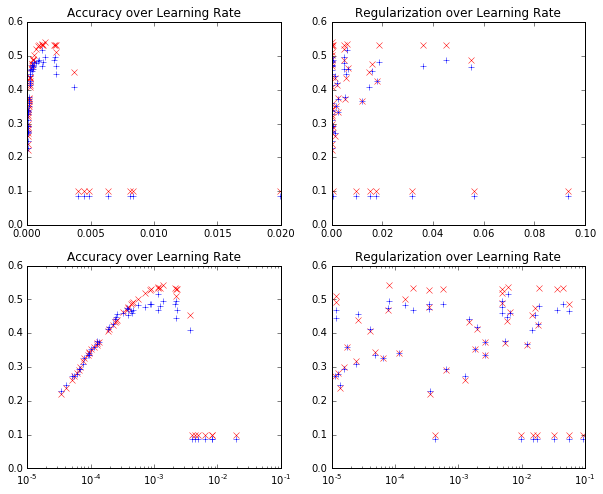

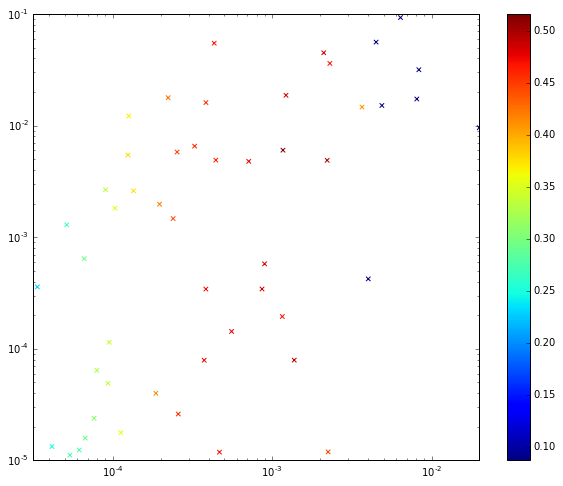

In [123]:
show_results(results, best_params, lr_ranges=lr_ranges_exp, reg_ranges=reg_ranges_exp)


Final Evaluations
HS: 60 #iter: 1500 #batch: 200 LR: 0.00551656  Reg: 0.56656698 ACC Test: 0.1 Val: 0.087
HS: 60 #iter: 1500 #batch: 200 LR: 0.00228795  Reg: 0.01489599 ACC Test: 0.52 Val: 0.492
HS: 60 #iter: 1500 #batch: 200 LR: 0.00047472  Reg: 0.06175216 ACC Test: 0.48 Val: 0.463
HS: 60 #iter: 1500 #batch: 200 LR: 0.00224810  Reg: 0.00007930 ACC Test: 0.498 Val: 0.453
HS: 60 #iter: 1500 #batch: 200 LR: 0.00114114  Reg: 0.00028833 ACC Test: 0.526 Val: 0.494
HS: 60 #iter: 1500 #batch: 200 LR: 0.00637176  Reg: 0.28476651 ACC Test: 0.1 Val: 0.087
HS: 60 #iter: 1500 #batch: 200 LR: 0.00290771  Reg: 0.03519220 ACC Test: 0.467 Val: 0.423
HS: 60 #iter: 1500 #batch: 200 LR: 0.00040934  Reg: 0.00168647 ACC Test: 0.472 Val: 0.453
HS: 60 #iter: 1500 #batch: 200 LR: 0.00064507  Reg: 0.00128991 ACC Test: 0.505 Val: 0.471
HS: 60 #iter: 1500 #batch: 200 LR: 0.00661671  Reg: 0.03526102 ACC Test: 0.1 Val: 0.087
HS: 60 #iter: 1500 #batch: 200 LR: 0.00044167  Reg: 0.00011181 ACC Test: 0.479 Val: 0.465

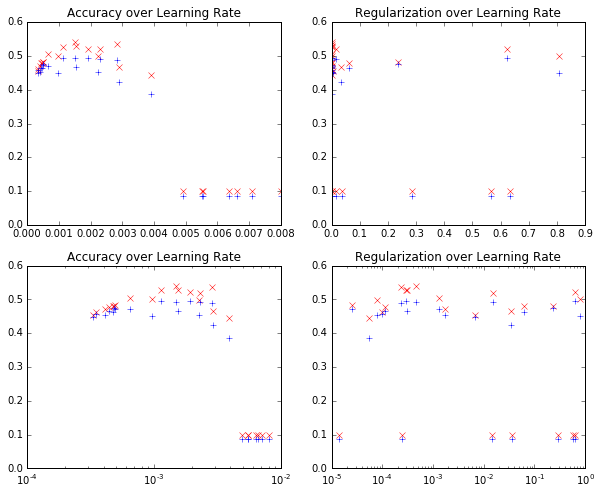

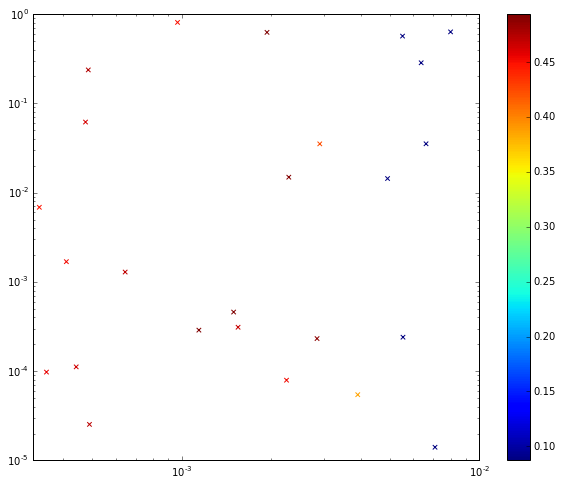

In [121]:
show_results(results, best_params, lr_ranges=lr_ranges_exp, reg_ranges=reg_ranges_exp)


Final Evaluations
HS: 60 #iter: 1000 #batch: 200 LR: 0.00001305  Reg: 0.10865049 ACC Test: 0.204 Val: 0.231
HS: 60 #iter: 1000 #batch: 200 LR: 0.00109197  Reg: 0.00041297 ACC Test: 0.494 Val: 0.462
HS: 60 #iter: 1000 #batch: 200 LR: 0.00004897  Reg: 0.00002378 ACC Test: 0.2 Val: 0.214
HS: 60 #iter: 1000 #batch: 200 LR: 0.00273753  Reg: 0.00012746 ACC Test: 0.456 Val: 0.41
HS: 60 #iter: 1000 #batch: 200 LR: 0.00003825  Reg: 0.00021856 ACC Test: 0.176 Val: 0.185
HS: 60 #iter: 1000 #batch: 200 LR: 0.00058099  Reg: 0.31509830 ACC Test: 0.46 Val: 0.448
HS: 60 #iter: 1000 #batch: 200 LR: 0.00039436  Reg: 0.00002080 ACC Test: 0.432 Val: 0.435
HS: 60 #iter: 1000 #batch: 200 LR: 0.00044351  Reg: 0.00186901 ACC Test: 0.443 Val: 0.448
HS: 60 #iter: 1000 #batch: 200 LR: 0.00010254  Reg: 0.00001136 ACC Test: 0.294 Val: 0.283
HS: 60 #iter: 1000 #batch: 200 LR: 0.00947571  Reg: 0.00001129 ACC Test: 0.1 Val: 0.087
HS: 60 #iter: 1000 #batch: 200 LR: 0.00223600  Reg: 0.00048711 ACC Test: 0.507 Val: 0.4

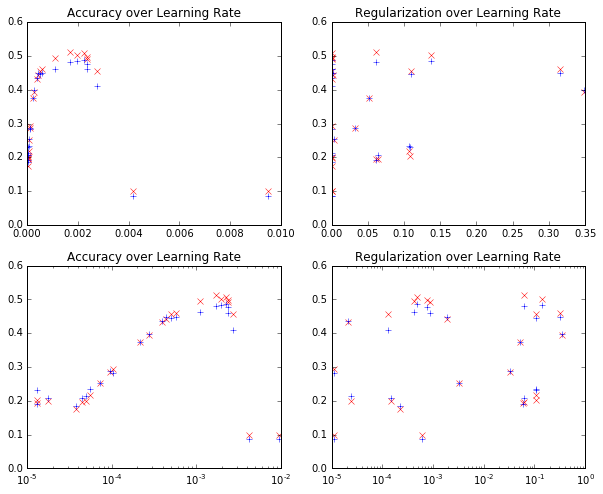

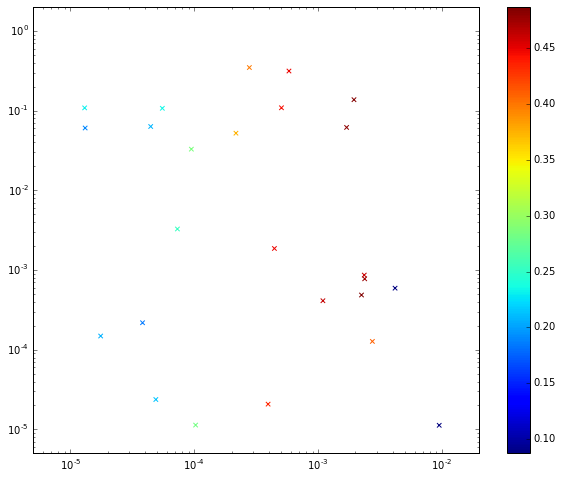

In [100]:
print "\nFinal Evaluations"
for k,r in results.items():
    print "HS: {} #iter: {} #batch: {} LR: {:.8f}  Reg: {:.8f} ACC Test: {:.3} Val: {:.3}".format(*(list(k)+list(r[:2])))
lr,reg,at,av = np.array([[k[3],k[4],r[0],r[1]] for k,r in results.items()]).T
plt.figure()
plt.subplot(221)
plt.plot(lr,at,'xr',label="Train")
plt.plot(lr,av,'+',label="Val")
plt.title("Accuracy over Learning Rate")
plt.subplot(223)
plt.semilogx(lr,at,'xr',label="Train")
plt.semilogx(lr,av,'+',label="Val")
plt.title("Accuracy over Learning Rate")
plt.subplot(222)
plt.plot(reg,at,'xr',label="Train")
plt.plot(reg,av,'+',label="Val")
plt.title("Regularization over Learning Rate")
plt.subplot(224)
plt.semilogx(reg,at,'xr',label="Train")
plt.semilogx(reg,av,'+',label="Val")
plt.title("Regularization over Learning Rate")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(lr, reg, marker='x',c=av, cmap=plt.get_cmap("jet"))
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(0.5e-5,2e-2) # Fix the x limits to fit all the points
plt.ylim(0.5e-5,2) # Fix the x limits to fit all the points
plt.colorbar();

0.487


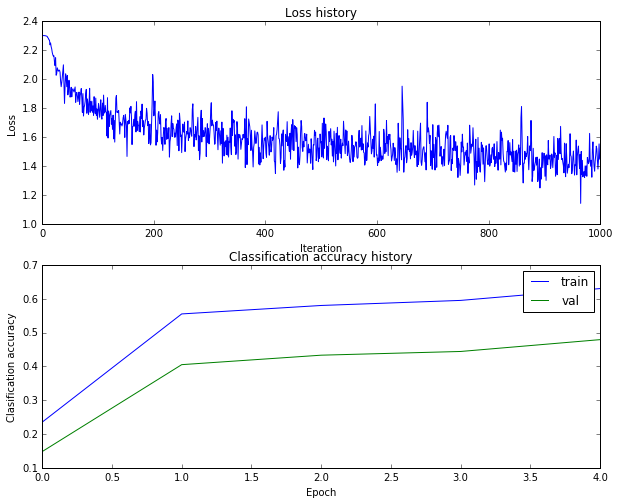

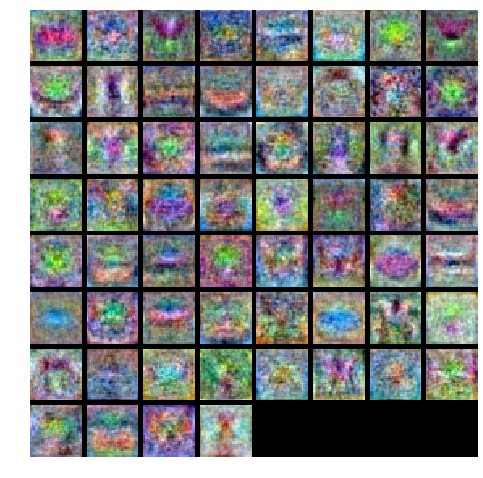

In [102]:
# visualize the weights of the best network
print best_val
show_stats_history(best_stats)
show_net_weights(best_net)

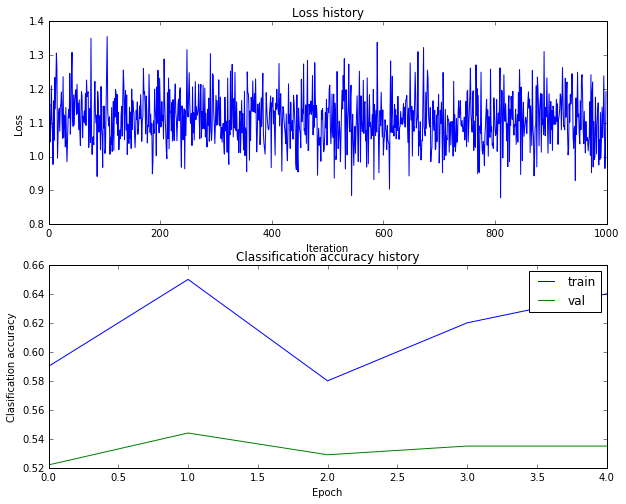

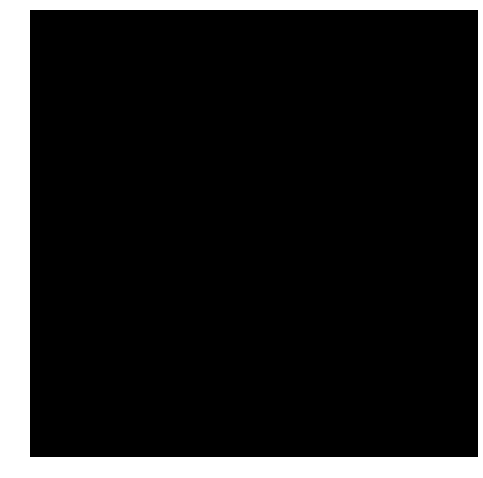

In [66]:
# visualize the weights of the best network
show_stats_history(best_stats)
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [30]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print 'Test accuracy: ', test_acc

Test accuracy:  0.523


In [157]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print 'Test accuracy: ', test_acc

Test accuracy:  0.529
